<div style="text-align: center;">
    <h1>Textual <strike>Semantic</strike> Similarity Analysis <br/>between Embeddings Techniques <br/> using Brazilian Legal Data</h1>
<div>

# Introdução

No contexto Legal, a recuperação de decisões anteriores sobre um assunto de interesse é utilizada como precedente e serve como argumentação e como base de decisão sobre uma nova peça jurídica do mesmo assunto.
Devido ao grande número de registros jurídicos, o uso de técnicas computacionais se fazem indispensáveis para a varredura de toda uma base de dados de modo a retornar itens de uma pesquisa em tempo satisfatório.

A busca baseada em palavras chaves é muito utilizada na área de Recuperação da Informação. Entre as técnicas utilizadas na busca por palavras chaves, o <i>Bag of Words</i> e o <i>TF-IDF</i> são as comuns. Essas técnicas geram uma abstração onde o texto tem sua forma simbólica representada numericamente de forma a tornar possível a comparação e cálculo de similaridade com diferentes textos.

Outras técnicas de representações textuais que geram as representações codificando também a semântica envolvida surgiram para diferentes níveis de segmentação textual, como palavras, parágrafos ou textos completos. Com isso, um mesmo texto pode ser representado numericamente de formas diferentes.

# Objetivo
O objetivo deste estudo é analisar as convergências e divergências entre representações textuais geradas por diferentes técnicas de embeddings. Para isso, será analisado quais documentos são recuperados por cada técnica dada um documento de consulta. Feito isso, será realizada uma comparação entre as recuperações entre diferentes representações para uma mesma consulta.

# Dados
Os dados utilizados serão textos de acórdãos do STJ e votos do TCU. Os dados foram recuperados por uma rotina de raspagem de dados dos sites dos respectivos órgãos. A particularidade desses dados consiste em serem <b>precedentes de jurisprudências</b> usadas pelos órgãos. Jurisprudências são entendimentos adotados por órgãos jurídicos que orientam qual deve ser a decisão para um determinado assunto. Esses entendimentos são formulados a partir da análise de decisões anteriores sobre o mesmo assunto, e tem como objetivo uniformizar as decisões e dar celeridade aos processos de assuntos recorrentes.

O total dos dados obtidos com o procedimento de raspagem é o seguinte:

In [1]:
import pandas as pd

stj_data = pd.read_csv("../datasets/jurisprudencias_stj_clean.csv").dropna().drop_duplicates()
tcu_data = pd.read_csv("../datasets/jurisprudencias_tcu.csv", index_col=0).dropna().drop_duplicates()

STJ: 
4899 Acórdãos
730 Jurisprudências
7 Matérias
68 Naturezas

Histograma precedentes por Jurisprudência: 


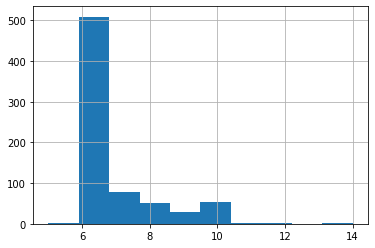

In [2]:
print("STJ: ")
print(len(stj_data), "Acórdãos")
print(len(stj_data.TEMA.unique()), "Jurisprudências")
print(len(stj_data.MATERIA.unique()), "Matérias")
print(len(stj_data.NATUREZA.unique()), "Naturezas\n")
print("Histograma precedentes por Jurisprudência: ")
stj_data.TEMA.value_counts().hist()

TCU: 
372 Acórdãos
44 Jurisprudências
4 Áreas
27 Temas
38 Subtemas

Histograma precedentes por Jurisprudência: 


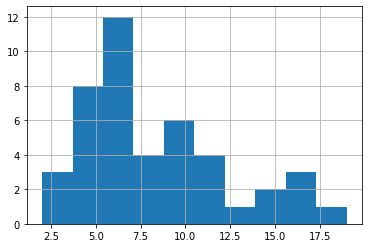

In [3]:
print("TCU: ")
print(len(tcu_data), "Acórdãos")
print(len(tcu_data.ENUNCIADO.unique()), "Jurisprudências")
print(len(tcu_data.AREA.unique()), "Áreas")
print(len(tcu_data.TEMA.unique()), "Temas")
print(len(tcu_data.SUBTEMA.unique()), "Subtemas\n")
print("Histograma precedentes por Jurisprudência: ")
tcu_data.ENUNCIADO.value_counts().hist()

# Embeddings similarities analysis

Para este estudo foram escolhidas as seguintes técnicas:

<table>
    <thead>
        <tr>
            <th>Model</th>
            <th>Setup</th>
            <th>vector size</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>TF-IDF</td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td>BM25</td>
            <td></td>
            <td></td>
        </tr>
        <tr>
            <td>word2vec</td>
            <td>mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>weighted word2vec</td>
            <td>TFIDF weighted + mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>fasttext</td>
            <td>mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>weighted fasttext</td>
            <td>TFIDF weighted + mean</td>
            <td>300</td>
        </tr>
        <tr>
            <td>Sentence Transformer</td>
            <td>Distill USE Multilingual</td>
            <td>512</td>
        </tr>
        <tr>
            <td>ELMo</td>
            <td>token embeddings mean</td>
            <td>1024</td>
        </tr>
        <tr>
            <td>BERT</td>
            <td>last 4 layers concat</td>
            <td>3072</td>
        </tr>
        <tr>
            <td>ITD BERT</td>
            <td>LM finetunned on ITD dataset, last 4 layers concat</td>
            <td>3072</td>
        </tr>
        <tr>
            <td>Longformer</td>
            <td>BERT based, last 4 layers concat</td>
            <td>3072</td>
        </tr>
        <tr>
            <td>ITD Longformer</td>
            <td>ITD BERT based, last 4 layers concat</td>
            <td>3072</td>
        </tr>
    </tbody>
</table>

O experimento consistiu em:
1) Gerar embedding para cada documento de cada conjunto de dados com cada uma das técnicas citadas
2) Recuperar os 5 documentos mais similares de cada documento do conjunto de dados com o auxílio do indexador Annoy e calcular a distância de cossenos entre as representações, exceto no caso do BM25 que tem uma dinâmica própria.
3) Salvar cada par de documentos similares de cada técnica em um arquivo CSV

O objetivo a partir daí é verificar as interseções dos pares de documentos similares gerados pelas diferentes técnicas. Para auxiliar na análise vamos usar a visualização <b>UpSet plots¹</b>.

A primeira análise será realizada a partir dos dados do TCU.

<p style='font-size:10px'>¹ Alexander Lex, Nils Gehlenborg, Hendrik Strobelt, Romain Vuillemot, Hanspeter Pfister, UpSet: Visualization of Intersecting Sets, IEEE Transactions on Visualization and Computer Graphics (InfoVis ‘14), vol. 20, no. 12, pp. 1983–1992, 2014. doi: doi.org/10.1109/TVCG.2014.2346248</p>


In [4]:
similarities = pd.read_csv("../results/tcu_similarities.csv", index_col=0)
models_dict = {}
for model_name, model_pairs in similarities.groupby("MODEL_NAME"):
    pairs = []
    for i, pair in model_pairs.iterrows():
        pairs.append((pair[0], pair[1]))
    models_dict[model_name] = set(pairs)

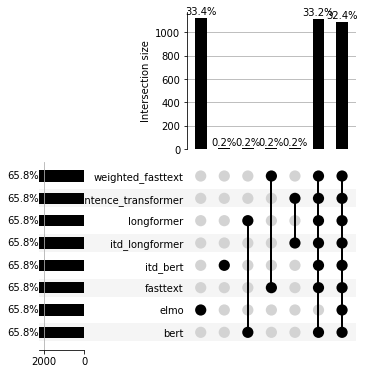

<Figure size 432x288 with 0 Axes>

In [5]:
from matplotlib import pyplot
from upsetplot import from_contents, plot

example = from_contents(models_dict)
plot(
    example, show_percentages=True,
)
# orientation='vertical'
pyplot.show()
pyplot.savefig("../results/tcu_similarities.png", bbox_inches="tight")

# Scatter plot with DensMAP Visualization

<b>DensMAP²</b> é uma técnica de redução de dimensionalidade para visualização de dados baseada no <b>UMAP³</b> que também se preocupa em criar espaços vetoriais reduzidos que respeitem de forma estimada a a densidade local das subpopulações dos dados a serem visualizados.


<p style='font-size:10px'>² NARAYAN, Ashwin; BERGER, Bonnie; CHO, Hyunghoon. Density-preserving data visualization unveils dynamic patterns of single-cell transcriptomic variability. bioRxiv, 2020.<p>
<p style='font-size:10px'>³ MCINNES, Leland; HEALY, John; MELVILLE, James. Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426, 2018.<p>

In [18]:
import os

import umap
from annoy import AnnoyIndex

vectors_size = {
    "bert.ann": 3072,
    "elmo.ann": 1024,
    "fasttext.ann": 300,
    "weighted_fasttext.ann": 300,
    "itd_bert.ann": 3072,
    "longformer.ann": 3072,
    "itd_longformer.ann": 3072,
    "sentence_transformer.ann": 512,
}

data = {}
files = os.listdir("../results")
for file in files:
    if file.endswith(".ann"):
        size = vectors_size[file.split("/")[-1]]
        ann = AnnoyIndex(size, "angular")
        ann.load("../results/" + file)  # super fast, will just mmap the file
        points = []
        for i in range(ann.get_n_items()):
            points.append(ann.get_item_vector(i))
        
        points_embeddings = umap.UMAP(densmap=True, random_state=42). \
                                fit_transform(points)
        data[file.split("/")[-1]] = points_embeddings

/opt/conda/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


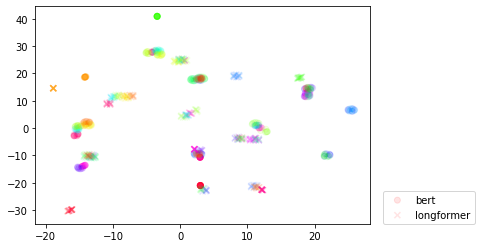

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

juris_enc = tcu_data.ENUNCIADO.astype('category').cat.codes.tolist()
cmap = get_cmap(len(list(set(juris_enc))))
juris_colors = [cmap(i) for i in juris_enc]

plt.scatter(data["bert.ann"][:, 0][:372], data["bert.ann"][:, 1][:372], 
            c=juris_colors, marker="o", label="bert", alpha=0.1)
plt.scatter(
    data["longformer.ann"][:, 0][:372], data["longformer.ann"][:, 1][:372], 
    c=juris_colors, marker="x", label="longformer", alpha=0.1)

plt.legend(loc=(1.04, 0))
plt.show()

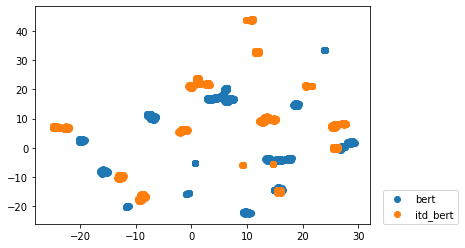

In [9]:
plt.scatter(data["bert.ann"][:, 0], data["bert.ann"][:, 1], label="bert")
plt.scatter(data["itd_bert.ann"][:, 0], data["itd_bert.ann"][:, 1], label="itd_bert")
plt.legend(loc=(1.04, 0))
plt.show()

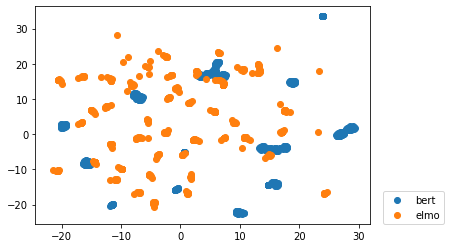

In [10]:
plt.scatter(data["bert.ann"][:, 0], data["bert.ann"][:, 1], label="bert")
plt.scatter(data["elmo.ann"][:, 0], data["elmo.ann"][:, 1], label="elmo")
plt.legend(loc=(1.04, 0))
plt.show()

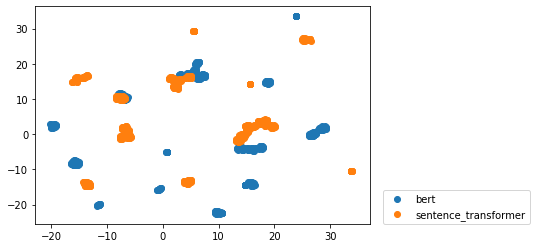

In [11]:
plt.scatter(data["bert.ann"][:, 0], data["bert.ann"][:, 1], label="bert")
plt.scatter(
    data["sentence_transformer.ann"][:, 0],
    data["sentence_transformer.ann"][:, 1],
    label="sentence_transformer",
)
plt.legend(loc=(1.04, 0))
plt.show()

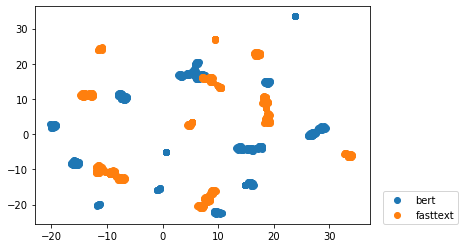

In [12]:
plt.scatter(data["bert.ann"][:, 0], data["bert.ann"][:, 1], label="bert")
plt.scatter(data["fasttext.ann"][:, 0], data["fasttext.ann"][:, 1], label="fasttext")
plt.legend(loc=(1.04, 0))
plt.show()

# Semantic Textual Similarity Dataset

A partir dos dados de jurisprudências de cada órgão foi gerado um conjunto de dados para a tarefa de STS. A premissa utilizada para a construção do conjunto de dados foi que acórdãos/votos de uma mesma jurisprudência guardam uma grande relação de similaridade. Ainda, metadados como matéria, natureza, ou tema dos textos de cada órgao também permitem inferir diferentes graus de similaridade entre textos distintos. Com isso, o conjunto de dados de STS gerado tem uma anotação fraca, pois os rótulos não foram produzidos por um anotador real, mas baseado em heurísticas provenientes dos metadados disponíveis.

In [13]:
tcu_sts = pd.read_csv("../datasets/tcu_sts.csv").drop_duplicates(
    subset=["sentence_A", "sentence_B"], keep="last"
)
stj_sts = pd.read_csv("../datasets/stj_sts.csv").drop_duplicates(
    subset=["sentence_A", "sentence_B"], keep="last"
)

In [14]:
print("Total de registros do TCU: ", len(tcu_sts))
print("Total de registros do STJ: ", len(stj_sts))

Total de registros do TCU:  4651
Total de registros do STJ:  41710


# How each embedding technique performs compared to STS dataset

In [15]:
import numpy as np

SOURCE_INDEX = 0
SIMILAR_INDEX = 1

sts_similarities = {}

for model, data in similarities.groupby("MODEL_NAME"):
    pairs_score = []
    for i, row in data.iterrows():
        sentence_A = tcu_data.iloc[row[SOURCE_INDEX]].VOTO
        sentence_B = tcu_data.iloc[row[SIMILAR_INDEX]].VOTO
        pair = tcu_sts[
            ((tcu_sts.sentence_A == sentence_A) & (tcu_sts.sentence_B == sentence_B))
            | ((tcu_sts.sentence_B == sentence_A) & (tcu_sts.sentence_A == sentence_B))
        ]
        if len(pair) > 0:
            pairs_score.append(pair.iloc[0].score)
        else:
            pairs_score.append(0)

    sts_similarities[model] = pairs_score

scores_stats = []
for model, scores in sts_similarities.items():
    #     print(model)
    #     print('Total de scores: ', len(scores))
    similars = [x for x in sts_similarities[model] if x != 0]
    non_similars = [x for x in sts_similarities[model] if x == 0]
    #     print('Total pares com alguma similaridade: ', len(similars))
    #     print('Média da Similaridade: ', np.mean(similars))
    #     print('Total pares sem similaridade atestada: ', len(non_similars))
    #     print('\n')
    scores_stats.append([model, len(similars), np.mean(similars)])

IndexError: single positional indexer is out-of-bounds

In [ ]:
print(
    "Total de pares similares gerados por cada técnica: ", len(sts_similarities["bert"])
)
print("\n")
df = pd.DataFrame(scores_stats, columns=["MODEL", "SIMILAR_NUMBER", "MEAN_SIMILARITY"])
fig = pyplot.figure()  # Create matplotlib figure

ax = fig.add_subplot(111)  # Create matplotlib axes
ax2 = ax.twinx()  # Create another axes that shares the same x-axis as ax.

width = 0.4

df.SIMILAR_NUMBER.plot(kind="bar", color="red", ax=ax, width=width, position=1)
df.MEAN_SIMILARITY.plot(kind="bar", ax=ax2, width=width, position=0)

ax.set_ylabel("Similar pairs on STS dataset")
ax2.set_ylabel("Mean Similarity from STS dataset")

ax.set_xticklabels(df.MODEL)

ax.legend(["Similar pairs on STS dataset"], loc=(1.1, 0.9))
ax2.legend(["Mean Similarity from STS dataset"], loc=(1.1, 0.8))
# fig.tight_layout()
plt.show()
df

# TODO

- Calcular os mais de cada documento numa representação para documentos de outra representação (p.ex.: BERT -> Longformer) e analisar com o conjunto de similares calculados dentro de uma mesma representação.
    - Verificar médias e variâncias


- Calcular a distância de um mesmo documento D1 entre duas representações diferentes (D1' -> D1'')
    - Recuperar o documento mais próximo do D1 em uma das representação (D2) e calcular a distância.
    - O que é mais próximo: o mesmo documento em representações diferentes ou o mais próximo do documento em uma representação fixada?
    - Verificar média das distâncias e mediana


- Consigo verificar se os grupos de diferentes representações são compostos dos mesmos documentos?


- Colorir os pontos em cada representação de acordo com a jurisprudência associada
    - Os pontos agrupados são de uma mesma jurisprudência?


- Existe alguma ferramenta que auxilie essa visualização de forma interativa?

- Quantidade de tokens por documento segundo cada forma de tokenização

- 

# Questões a serem respondidas

- O tamanho do contexto importa? Longformer >> BERT?
- Há uma grande diferença no cálculo de similaridade entre diferentes arquiteturas? BERT != ELMo
- A Language Model base importa muito? BERT (BERTimbau) != Sentence Transformer (Distill USE Multilingual)
- Como se diferem entre si as abordagens frequentistas, agrupamento de vetores e contextualizas (com trasformer ou não)
- _Aline: "Daniel, uma coisa que esqueci de perguntar ontem: quando o tamanho do seu documento é maior que a entrada do modelo (no caso dos transformers, em particular), o que você faz? Fiquei me perguntando se esses seriam os mais representativos do documento."_
    - _Daniel: "Aí isso depende do foco de um analista. Por exemplo, na maior parte desse documentos, o começo é um resumo de tudo que envolve o processo, do meio pro fim acaba sendo o julgamento em si. Numa visão mais ampla, o resumo é mais útil pra similaridade. Mas a similaridade num grão mais fino se valeria melhor do restante do documento. Seria como usar o começo dos textos fosse um filtro grosseiro, e o resto do documento um filtro bem específico."_